# Image classification with Keras

![](http://)## Install dependencies

In [12]:
%matplotlib inline
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw
from scipy.ndimage.filters import gaussian_filter
from scipy import ndimage

from keras import regularizers, optimizers
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D, Conv2D, MaxPool2D, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import (
    random_rotation, random_shift, random_shear, random_zoom,
    random_channel_shift, img_to_array, ImageDataGenerator)
from keras import backend as K
from keras.datasets import fashion_mnist
from keras_tqdm import TQDMCallback, TQDMNotebookCallback
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils import class_weight
print("import is ready")

import is ready


In [13]:
# set consistent random seed
random_seed = 2018
np.random.seed(random_seed)  
tf.set_random_seed(random_seed)

## Dataset
Whales dataset

### Show the content of the current and parent folder

In [14]:
print(os.listdir(".."))
print(os.listdir("."))

['tracking.txt', 'humpback-whale-identification.zip', 'extract_labels.py', 'test.csv', 'whales_small', 'kernel', 'input', 'miscellanous', '.ipynb_checkpoints', 'results.csv', 'results_pred.csv', 'kernel_categorical_accuracy.ipynb', '.directory', '.gitignore', '.git']
['kernel.ipynb', 'kernel(1).ipynb', '128', '8192', 'kernel_vgg19_adapted.ipynb', '.ipynb_checkpoints', 'submit.csv', 'results.csv', 'results_pred.csv', 'kernel_pre_mlp.ipynb']


### Show the content of the input folder

In [15]:
print(os.listdir("../input"))

['sample_submission.csv', 'test.zip', 'train.csv', 'train.zip', 'train', 'test', '.ipynb_checkpoints']


### Importing, normalizing, visualizing

Let's upload whales dataset.

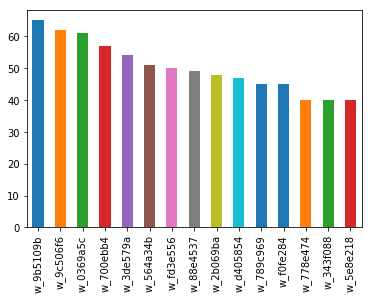

In [16]:
# flow_from_dataframe
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
traindf=pd.read_csv("../input/train.csv",dtype=str)
# remove new whales from input
traindf = traindf[traindf.Id != "new_whale"]
# remove single whales values
# traindf = traindf.groupby('Id').filter(lambda x: len(x) > 1)
# plot Id frequencies
traindf['Id'].value_counts()[1:16].plot(kind='bar')

testdf=pd.read_csv("../input/sample_submission.csv",dtype=str)

# datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)
datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.5,
        zoom_range=(0.9, 1.1),
        horizontal_flip=False,
        vertical_flip=False,
        fill_mode='constant',
        cval=0,
        rescale=1./255.,
        validation_split=0.25    
)

Print obtained dataframes for checking

In [17]:
traindf.shape
# Calculate number of unique classes (whales)
number_of_classes = traindf['Id'].nunique()

In [18]:
testdf.head(1)

,Image,Id
0,00028a005.jpg,new_whale w_23a388d w_9b5109b w_9c506f6 w_0369a5c


In [19]:
# Pass the dataframes to 2 different flow_from_dataframe functions
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
train_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="../input/train/",
x_col="Image",
y_col="Id",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(80,80))

valid_generator=datagen.flow_from_dataframe(
dataframe=traindf,
directory="../input/train/",
x_col="Image",
y_col="Id",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(80,80))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
dataframe=testdf,
directory="../input/test/",
x_col="Image",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(80,80))


Found 11823 images belonging to 5004 classes.
Found 3874 images belonging to 5004 classes.
Found 7960 images.


In [20]:
# Model @frommedium
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(80,80,3)))
model.add(Dense(512, activation='relu'))
model.add(Dense(number_of_classes, activation='softmax'))
model.compile(optimizers.rmsprop(lr=0.0001, decay=1e-6),loss="categorical_crossentropy",metrics=["accuracy"])

print("The model is ready")


The model is ready


In [21]:
# Fit the model @frommedium
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
# Class weights balancing
history = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    class_weight='auto',
                    epochs=1
)

In [22]:
# history plots
"""
plt.plot(history.history['categorical_crossentropy'])
plt.title('Model categorical crossentropy')
plt.ylabel('categorical crossentropy')
plt.xlabel('Epoch')
plt.show()
"""

plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.show()

# Plot the loss curve for training
plt.plot(history.history['loss'], color='r', label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


KeyError: 'acc'

In [ ]:
# Evaluate model
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
model.evaluate_generator(generator=valid_generator, steps=1)

In [ ]:
print(os.listdir("."))

In [ ]:
# Predict the output
# https://medium.com/@vijayabhaskar96/tutorial-on-keras-flow-from-dataframe-1fd4493d237c

test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST+1,
verbose=1)

predicted_class_indices=np.argmax(pred,axis=1)

labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

filenames=test_generator.filenames


print("filenames were prepared")

In [ ]:
# multiple classes output
# https://www.kaggle.com/hexadd5/simple-resnet50-with-keras
kth = 5
classes = np.array([c for c, v in train_generator.class_indices.items()])

if True:
    classify_index = np.argpartition(-pred, kth)[:, :kth]
    classify_value = pred[np.arange(pred.shape[0])[:, None], classify_index]
    best_5_pred = np.zeros((len(classify_index), 5))
    best_5_class = np.zeros((len(classify_index), 5), dtype='int32')
    for i, p in enumerate(classify_value):
        sort_index = np.argsort(p)[::-1]
        best_5_pred[i] = (p[sort_index])
        best_5_class[i] = (classify_index[i][sort_index])
        
    # create output
    submit = pd.DataFrame(columns=['Image', 'Id'])
    for i, p in enumerate(best_5_pred):
        submit_classes = []
        if p[0] < 0.55:
            submit_classes.append('new_whale')
            submit_classes.extend(classes[best_5_class[i]][0:4])
        elif p[1] < 0.4 :
            submit_classes.extend(classes[best_5_class[i]][0:1])
            submit_classes.append('new_whale')
            submit_classes.extend(classes[best_5_class[i]][1:4])
        elif p[2] < 0.1 :
            submit_classes.extend(classes[best_5_class[i]][0:2])
            submit_classes.append('new_whale')
            submit_classes.extend(classes[best_5_class[i]][2:4])
        elif p[3] < 0.05 :
            submit_classes.extend(classes[best_5_class[i]][0:3])
            submit_classes.append('new_whale')
            submit_classes.extend(classes[best_5_class[i]][3:4])
        else:
            submit_classes.extend(classes[best_5_class[i]])
        classes_text = ' '.join(submit_classes)
        submit = submit.append(pd.Series(np.array([test_generator.filenames[i], classes_text]), index=submit.columns), ignore_index=True)
        # print(submit)
    submit.to_csv('submit.csv', index=False)
    print("submit results were written to the output")

In [ ]:
print(os.listdir("."))
results=pd.DataFrame({"Filename":filenames})
results_pred=pd.DataFrame({"Predictions":predictions})
results.to_csv("results.csv",index=False)
results_pred.to_csv("results_pred.csv",index=False)
print(os.listdir(".."))
print("results were written to the output")